**Table of contents**<a id='toc0_'></a>    
- 1. [Preface             ](#toc1_)    
- 2. [Load datasets            ](#toc2_)    
  - 2.1. [Load earthquake catalog            ](#toc2_1_)    
  - 2.2. [Load PNSN tremor catalog (Wech)            ](#toc2_2_)    
    - 2.2.1. [(Pick the line on which events are projected, optional, can load)            ](#toc2_2_1_)    
  - 2.3. [Select earthquakes in the tremor region            ](#toc2_3_)    
- 3. [Correlation matrix / distance          ](#toc3_)    
  - 3.1. [Try for two bins only         ](#toc3_1_)    
  - 3.2. [Computing cross-correlation matrix         ](#toc3_2_)    
  - 3.3. [Measuring correlation distance in the matrix         ](#toc3_3_)    
    - 3.3.1. [Using a function that fits the data to a line and measures the distance from the line to the data points.   ](#toc3_3_1_)    
    - 3.3.2. [Using a simple threshold   ](#toc3_3_2_)    
- 4. [Intensity of triggering in the tremor region  ](#toc4_)    
  - 4.1. [In time ](#toc4_1_)    
  - 4.2. [In space](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Preface              [&#128285;](#toc0_)

In [11]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets             [&#128285;](#toc0_)

In [12]:
# Constants for everyone
day0 = np.datetime64('2009-08-01') 

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog             [&#128285;](#toc0_)

In [ ]:
# Load USGS catalog

In [3]:
# Download usgs catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2009-08-01"
t1 = "2024-04-04"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = 39
maxlat = 54
minlon = -128
maxlon = -121
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 1.6
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
print(url)
stream = requests.get(url).content

names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
eq['date'] = pd.to_datetime(eq.time, format='%Y-%m-%dT%H:%M:%S.%fZ')

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2009-08-01&endtime=2024-04-04&minlatitude=39&maxlatitude=54&minlongitude=-128&maxlongitude=-121&minmagnitude=1.6&eventtype=earthquake


## 2.2. <a id='toc2_2_'></a>Load PNSN tremor catalog (Wech)             [&#128285;](#toc0_)

In [4]:
# Load tremor
path = workdir + 'projects/data/Catalogs/cascadia_tremor/tremor_all_cascadia_09_24.csv'
names = ['lat', 'lon', 'depth', 'starttime', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)
tremor['date'] = pd.to_datetime(tremor['starttime'])

# Find str in duration of tremor and convert them to float by stripping the space and converting to float (still misses some ' None ', don't know what to do with them...)
tremor.duration = tremor.duration.apply(lambda x: float(x.strip()) if x is str else x)

# Sort tremor by date
tremor = tremor.sort_values('date')

# Compute the day in the sequence for tremor
day0 = np.datetime64('2009-08-01')
tremor['day'] = (tremor.date - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_21494/3805188776.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


### 2.2.1. <a id='toc2_2_1_'></a>(Pick the line on which events are projected, optional, can load)             [&#128285;](#toc0_)

In [5]:
# # Select points that define tremor region 
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# # Create an empty array to store the picked locations
# picked_locations = []
# # Define the on_click event handler function
# def on_click(event):
#     if event.inaxes == ax:
#         # Get the latitude and longitude of the clicked point
#         lat, lon = event.ydata, event.xdata
#         picked_locations.append((lat, lon))
#         print(f"Point picked: Latitude={lat}, Longitude={lon}")

#         ax.plot([pl[1] for pl in picked_locations], [pl[0] for pl in picked_locations], 'ro-', transform=ccrs.PlateCarree())
#         plt.draw()

# # Connect the on_click event handler to the figure
# fig.canvas.mpl_connect('button_press_event', on_click)

# # Add coastlines
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# # Add states
# ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# # Add tremor
# ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# # Set extent for Cascadia subduction zone
# extent = [-128, -121, 39, 52]
# ax.set_extent(extent)

In [6]:
# # Save picked locations
# plt.close()

# picked_locations = np.array(picked_locations)
# np.savetxt('data/cascadia/tremor_region_line.txt', picked_locations)

## 2.3. <a id='toc2_3_'></a>Select earthquakes in the tremor region             [&#128285;](#toc0_)

In [8]:
# Project onto a straight line
# --> Define center line of tremor
lat_center = np.arange(39, 52, 0.2)
dlat = 0.4
center_line = np.zeros((len(lat_center), 2))

for ii, lat in enumerate(lat_center):
    lat_min = lat - dlat
    lat_max = lat + dlat
    tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
    center_line[ii, 1] = (lat_min + lat_max) / 2
    center_line[ii, 0] = tremor_bin.lon.median()

# --> Fit it with a straight line to find the transect points
p = np.polyfit(center_line[~np.isnan(center_line[:, 0]), 1], center_line[~np.isnan(center_line[:, 0]), 0], 1)
N_point = p[0] * 52 + p[1]
S_point = p[0] * 39 + p[1]
transect_line = {'N':{'lat': 52, 'lon': N_point}, 'S': {'lat': 39, 'lon': S_point}}

# --> Project earthquakes onto the line
t = transect(eq.lon.values, eq.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]

# --> Project tremor onto the line
t = transect(tremor.lon.values, tremor.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
tremor['xf'] = t[0]
tremor['yf'] = t[1]

UFuncTypeError: ufunc 'less_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [ ]:
# # To project onto more complex curve
# # for instance taking the median longitude of tremor for latitude bins
# # https://stackoverflow.com/questions/67490884/distance-between-a-point-and-a-curve-in-python
# # Even better, for better 

# # --> Define center line of tremor
# lat_center = np.arange(39, 52, 0.2)
# dlat = 0.4
# center_line = np.zeros((len(lat_center), 2))

# for ii, lat in enumerate(lat_center):
#     lat_min = lat - dlat
#     lat_max = lat + dlat
#     tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
#     center_line[ii, 1] = (lat_min + lat_max) / 2
#     center_line[ii, 0] = tremor_bin.lon.median()

# plt.figure()
# plt.plot(center_line[:, 0], center_line[:, 1], 'r--')
# plt.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5)
# plt.show()

# # --> Find the closest point on the line to each earthquake
# def distance(x, y, x0, y0):
#     "(x,y) line to consider, (x0, y0) sample point (event)"
#     d_x = x - x0
#     d_y = y - y0
#     dis = d_x**2 + d_y**2  # speeds it up to not take the sqrt
#     return dis


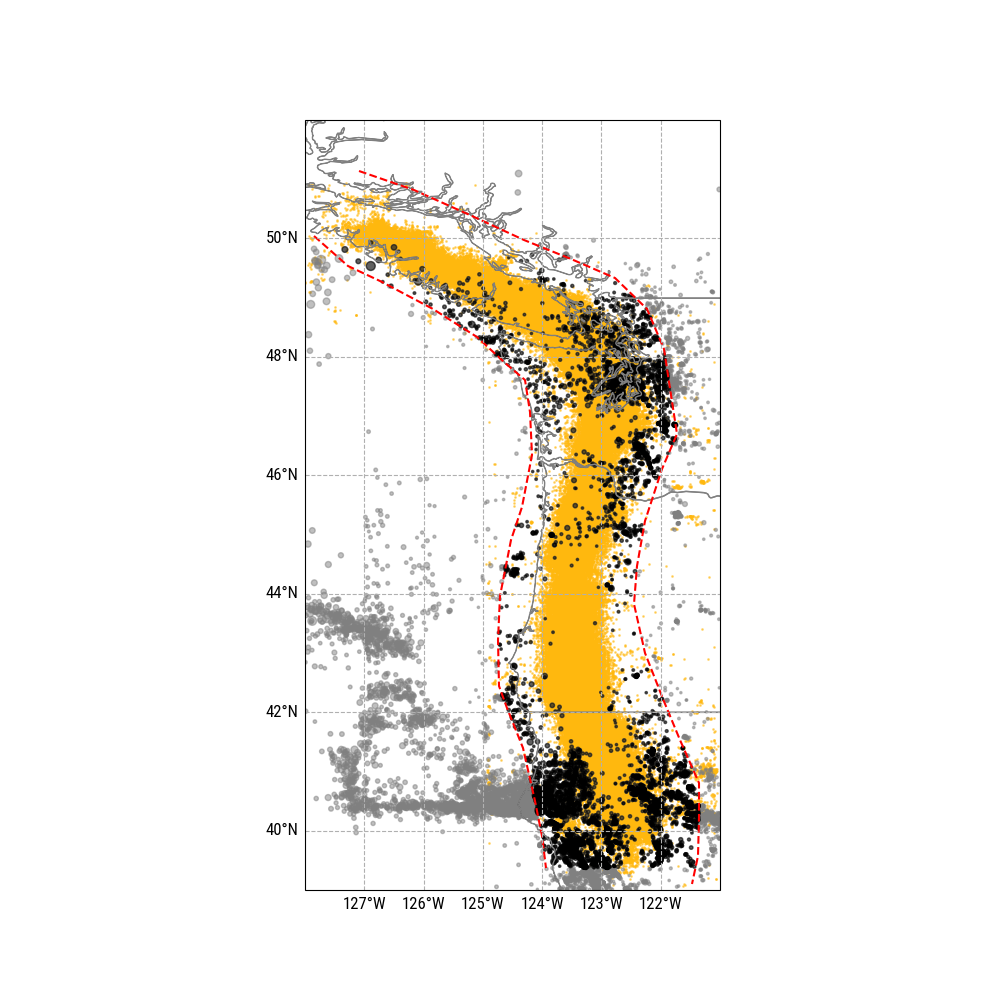

In [ ]:
# Find which points are left or right of the line drawn on the map
east_line = np.loadtxt('data/cascadia/tremor_region_east_line.txt')
west_line = np.loadtxt('data/cascadia/tremor_region_west_line.txt')

# For each earthquake
def which_side(M, A, B):
    return np.sign((B[0] - A[0]) * (M[1] - A[1]) - (B[1] - A[1]) * (M[0] - A[0]))

# For each earthquake, find the points of the line it's longitude is between, and then using those points, find if the earthquake is left or right of the line
eq['east'] = np.zeros(len(eq))
eq['west'] = np.zeros(len(eq))
for ii, row in eq.iterrows():
    M = (row['lon'], row['lat'])
    for jj in range(len(east_line)-1):
        A = (east_line[jj][1], east_line[jj][0])
        B = (east_line[jj+1][1], east_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'east'] = side
    for jj in range(len(west_line)-1):
        A = (west_line[jj][1], west_line[jj][0])
        B = (west_line[jj+1][1], west_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'west'] = side

eq_near = eq[(eq.east == -1) & (eq.west == 1)]

%matplotlib widget
# Map of data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# Add states
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# Add earthquakes
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, color='.5', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(eq_near.lon, eq_near.lat, s=eq_near.mag**2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# Add tremor
ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# Show east and west lines
ax.plot(east_line[:, 1], east_line[:, 0], 'r--', transform=ccrs.PlateCarree())
ax.plot(west_line[:, 1], west_line[:, 0], 'r--', transform=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Set extent for Cascadia subduction zone
extent = [-128, -121, 39, 52]
ax.set_extent(extent)

plt.show()

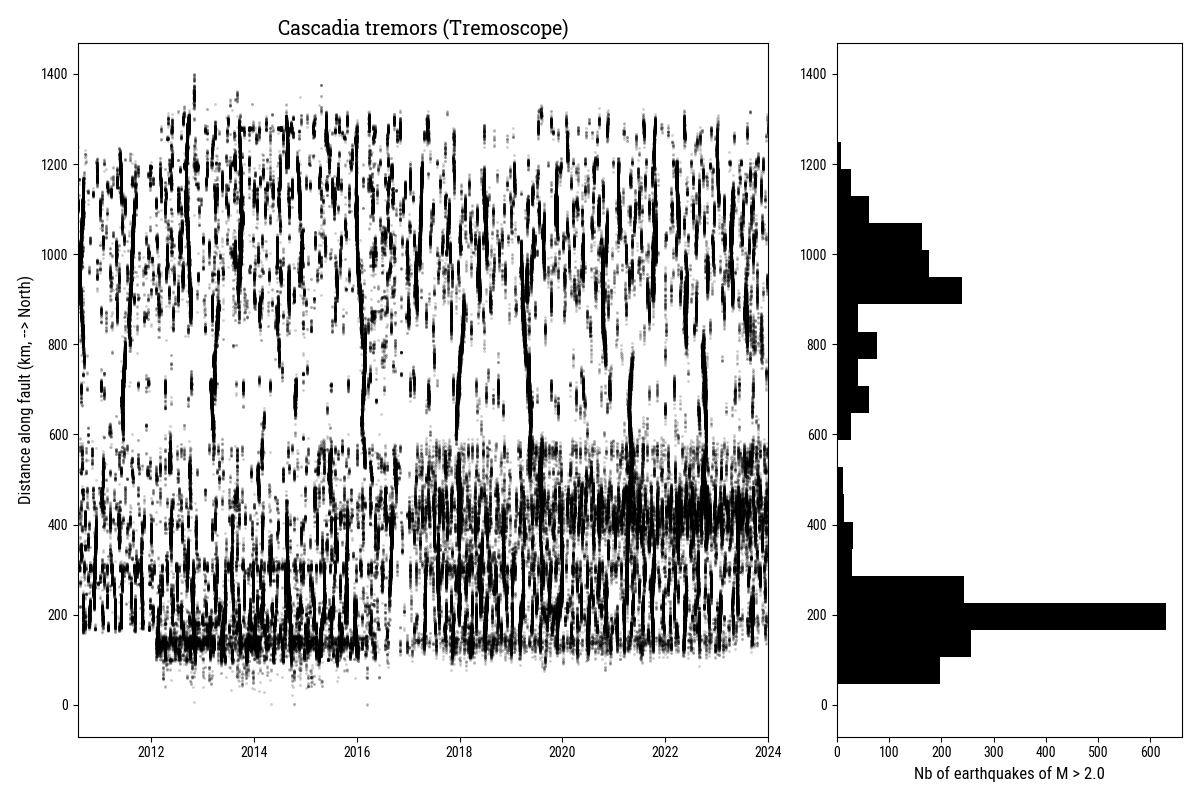

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Cascadia tremors (Tremoscope)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(tremor.date, tremor.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax.set_xlim(np.datetime64('2010-08-01'), np.datetime64('2024-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq_near.xf[(eq_near.mag > min_m) & (eq_near.depth < 65) & (eq_near.depth > 10)], bins=20, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Correlation matrix / distance           [&#128285;](#toc0_)

## 3.1. <a id='toc3_1_'></a>Try for two bins only          [&#128285;](#toc0_)

In [ ]:
from stats import cross_corr
import scipy.signal as ssg
%matplotlib widget

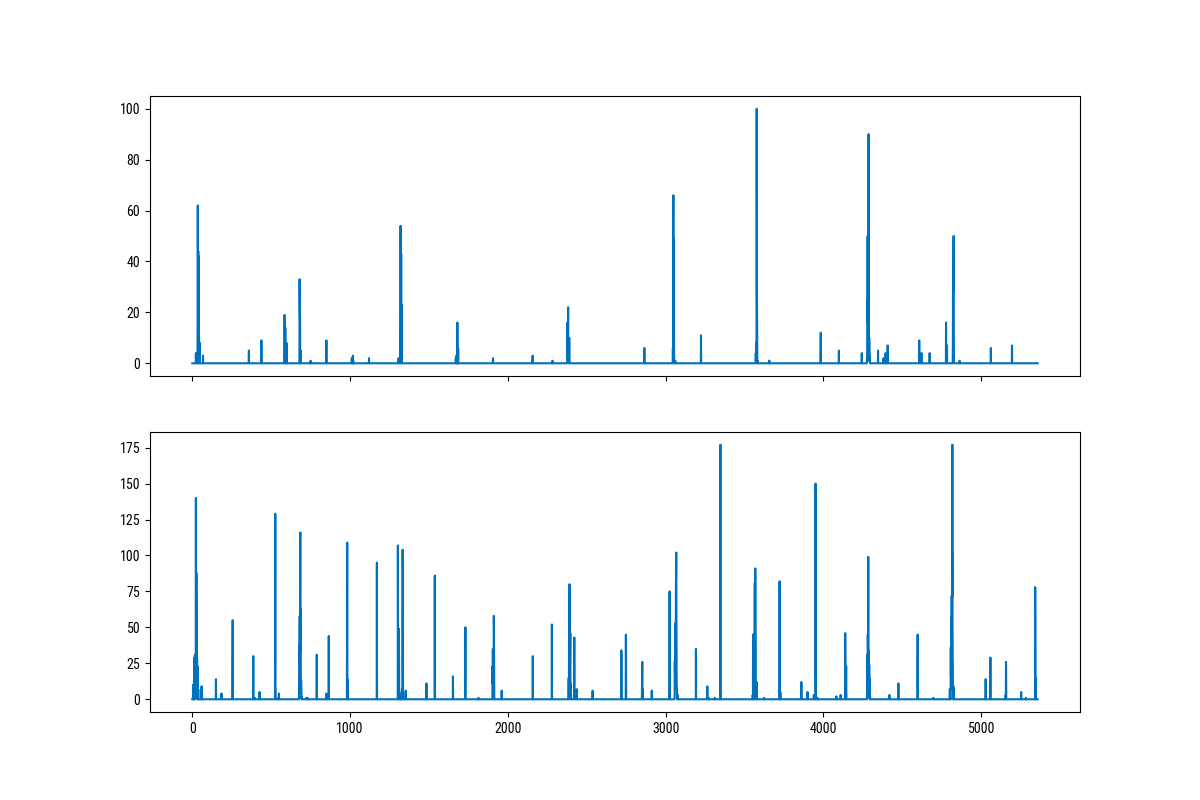

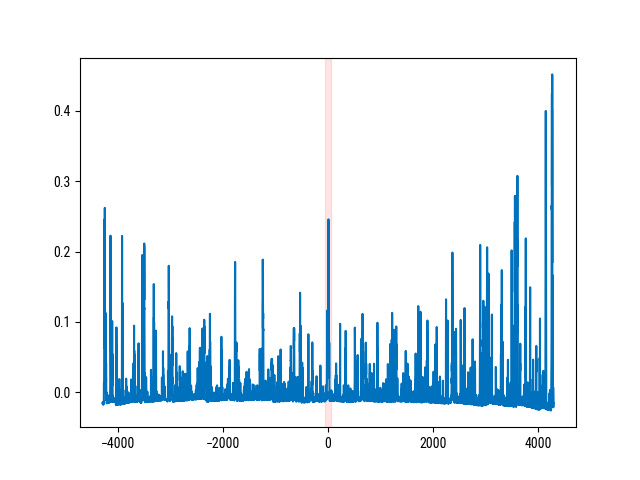

In [ ]:
# Cross-corr of just 2 bins
bin1 = [600, 620]
bin2 = [700, 720]
v_min = 2.  # km/day, slowest I could find is ~4 km/day

tremor_in_bin1 = tremor.xf.between(bin1[0], bin1[1])
tremor_in_bin2 = tremor.xf.between(bin2[0], bin2[1])

delta = 1

count_bin1 = np.histogram(tremor[tremor_in_bin1].day.values, bins=np.arange(0, tremor.day.max()+delta, delta))[0]
count_bin2 = np.histogram(tremor[tremor_in_bin2].day.values, bins=np.arange(0, tremor.day.max()+delta, delta))[0]

cc, lag = cross_corr(count_bin1, count_bin2, delta, norm=True, no_bias=True)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax = axes[0]
ax.plot(count_bin1)

ax = axes[1]
ax.plot(count_bin2)
plt.show()

# Folding around 0 to get something symmetrical
fig, ax = plt.subplots()
#ax.plot(lag, (cc+cc[::-1])/2)
ax.plot(lag, cc)
ax.axvspan(abs(np.mean(bin1) - np.mean(bin2)) / v_min,
           -abs(np.mean(bin1) - np.mean(bin2)) / v_min, color='r', alpha=.1)
plt.show()

In [ ]:
# # Check how one bin correlates with others in space (good way to find min velocity of clusters to consider)
# bins = np.arange(700, 1000, 10)
# v_min = 3.5  # km/day, slowest I could find is ~4 km/day
# tremor_in_bin0 = tremor.xf.between(bins[0], bins[1])
# count_bin0 = np.histogram(tremor[tremor_in_bin0].day.values, bins=np.arange(0, tremor.day.max()+delta, delta))[0]

# fig, axes = plt.subplots(len(bins), 1, figsize=(12, 12), sharex=True)
# for ax in axes:
#     ax.set_xlim(-300, 300)
#     ax.set_ylim(0, .4)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# for ii, xmin in enumerate(bins):
#     xmax = xmin + 10
#     tremor_in_bin = tremor.xf.between(xmin, xmax)
#     count_bin = np.histogram(tremor[tremor_in_bin].day.values, bins=np.arange(0, tremor.day.max()+delta, delta))[0]

#     cc, lag = cross_corr(count_bin0, count_bin, delta, norm=True, no_bias=True)
#     cc = (cc + cc[::-1]) / 2

#     ax = axes[ii]
#     ax.plot(lag, cc)
#     ax.axvspan((bins[0] - (xmin + 5))/v_min, (xmin + 5 - bins[0])/v_min, color='r', alpha=.1)

## 3.2. <a id='toc3_2_'></a>Computing cross-correlation matrix          [&#128285;](#toc0_)

In [ ]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 40  # in km, width of bin
xmin_bin = 100
xmax_bin = 1300
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [ ]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, tremor.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    tremor_in_bin = tremor.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(tremor[tremor_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
            if look_both_ways:
                cc = (cc + cc[::-1]) / 2
                cc = cc[lag >= 0]
                lag = lag[lag >= 0]
            
            in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
            cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
            lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

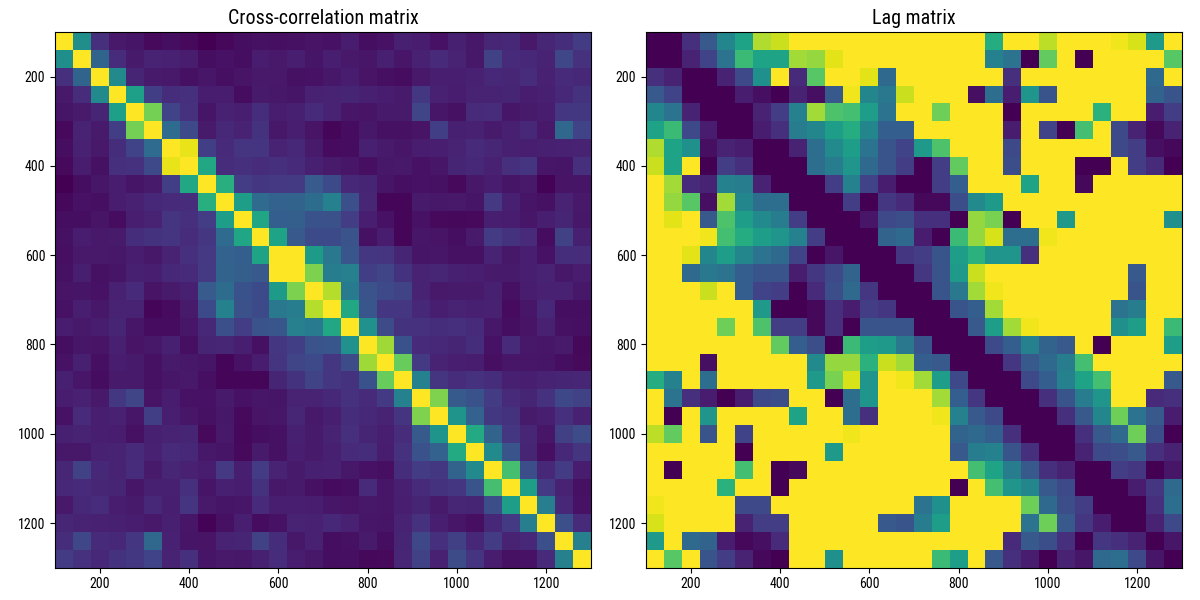

In [ ]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

# cc_matrix_sm = ssg.convolve2d(cc_matrix, np.ones((3, 3)), mode='full') / 9

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmax=.5)
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmin=0, vmax=50)
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

## 3.3. <a id='toc3_3_'></a>Measuring correlation distance in the matrix          [&#128285;](#toc0_)

### 3.3.1. <a id='toc3_3_1_'></a>Using a function that fits the data to a line and measures the distance from the line to the data points.    [&#128285;](#toc0_)

620
51.71176167399336 34.83821545733308


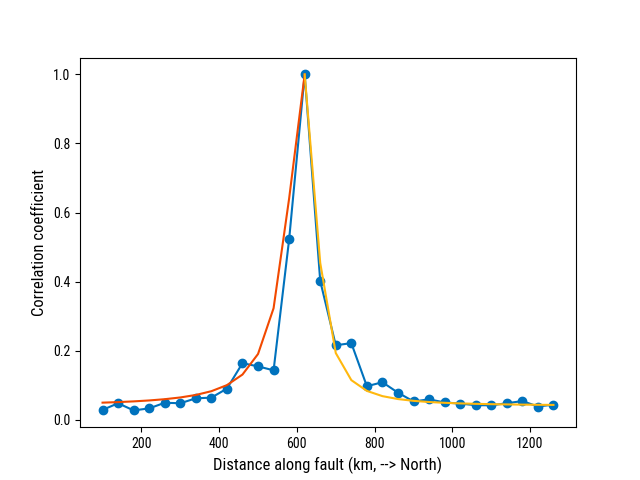

In [ ]:
# Try fitting a function to get the width of the correlation
from scipy.optimize import curve_fit

ii = 13
print(x_bin_edges[ii])

x0 = x_bin_edges[ii]
def gaussian_at_x0(x, sigma):
    c = np.quantile(cc_matrix, .3)
    return (1-c)*np.exp(-(x - x0)**2 / (2 * sigma**2)) + c

def lorentzian_at_x0(x, gamma):
    c = np.quantile(cc_matrix, .3)
    return (1-c) / (1 + (x - x0)**2 / gamma**2) + c

def exponential_at_x0(x, tau):
    c = np.quantile(cc_matrix, .3)
    return (1-c) * np.exp(-abs(x - x0) / tau) + c

# No smoothing
x_left = x_bin_edges[:ii+1]
x_right = x_bin_edges[ii:-1]
cc_left = cc_matrix[ii, :ii+1]
cc_right = cc_matrix[ii, ii:]

# Left side fit
popt_left, pcov_left = curve_fit(exponential_at_x0, x_left, cc_left, p0=[50])
# Right side fit
popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_right, cc_right, p0=[50])


# if smooth:
#     # Smoothed
#     cc_left_sm = np.convolve(cc_left.flatten(), np.ones(3), mode='same') / 3
#     cc_right_sm = np.convolve(cc_right.flatten(), np.ones(3), mode='same') / 3

#     # Left side fit
#     popt_left, pcov_left = curve_fit(exponential_at_x0, x_bin_edges[:ii], cc_left_sm[:-1], p0=[50])
#     # Right side fit
#     popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges[ii+1:-1], cc_right_sm[1:], p0=[50])


#     cc_left_sm = np.convolve(cc_left.flatten(), np.ones(3), mode='same') / 3
#     cc_right_sm = np.convolve(cc_right.flatten(), np.ones(3), mode='same') / 3


# Left side fit
popt_left, pcov_left = curve_fit(exponential_at_x0, x_left, cc_left, p0=[50])
# Right side fit
popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_right, cc_right, p0=[50])

print(popt_left[0], popt_right[0])

# Show
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation coefficient')

ax.plot(x_bin_edges[:-1], cc_matrix[:, ii], 'o-')

ax.plot(x_left, lorentzian_at_x0(x_left, *popt_left))
ax.plot(x_right, lorentzian_at_x0(x_right, *popt_right))

plt.show()

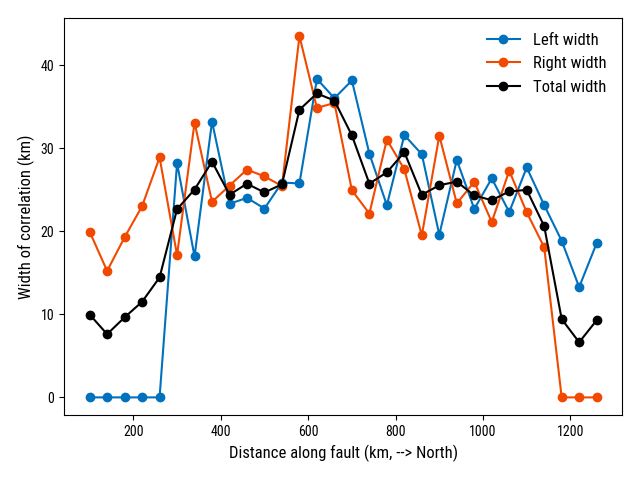

In [ ]:
# Compute the correlation distances
left_width = []
right_width = []

min_fit_points = 5  # minimum number of points to fit the width
q_cc0 = .3  # quantile of cc_matrix to consider as background, typically .3


for ii in range(len(x_bin_edges)-1):
    x0 = x_bin_edges[ii]

    def lorentzian_at_x0(x, gamma):
        c = np.quantile(cc_matrix, q_cc0)
        return (1-c) / (1 + (x - x0)**2 / gamma**2) + c
    
    def exponential_at_x0(x, tau):
        c = np.quantile(cc_matrix, q_cc0)
        return (1-c) * np.exp(-abs(x - x0) / tau) + c
    
    x_left = x_bin_edges[:ii+1]
    x_right = x_bin_edges[ii:-1]

    cc_left = cc_matrix[ii, :ii+1]
    cc_right = cc_matrix[ii, ii:]

    if ii < min_fit_points:
        popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_right, cc_right, p0=[50])

        left_width.append(0)
        right_width.append(popt_right[0])
    elif ii > len(x_bin_edges) - min_fit_points:
        popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_left, cc_left, p0=[50])

        left_width.append(popt_left[0])
        right_width.append(0)
    else:
        popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_left, cc_left, p0=[50])
        popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_right, cc_right, p0=[50])

        left_width.append(popt_left[0])
        right_width.append(popt_right[0])

# Show
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, 'o-', label='Left width')
ax.plot(x_bin_edges[:-1], right_width, 'o-', label='Right width')
ax.plot(x_bin_edges[:-1], (np.array(left_width) + np.array(right_width))/2, 'ko-', label='Total width')
ax.legend()
plt.tight_layout()
plt.show()

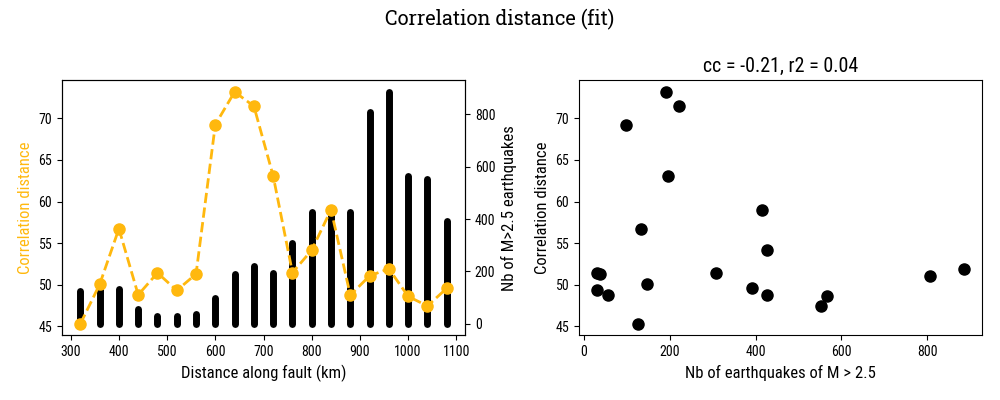

In [ ]:
# So... do they correlate?
corr_dist = np.array(left_width) + np.array(right_width)
n_eq_bin = np.zeros_like(x_bin_edges[:-1])
dx_eq = 20
for ii in range(len(x_bin_edges)-1):
    n_eq_bin[ii] = len(eq_near[(eq_near.xf >= x_bin_edges[ii]-dx_eq) & (eq_near.xf <= x_bin_edges[ii+1]+dx_eq)])

x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
corr_dist = corr_dist[(x_bin_centers >= xmin_bin + dx_bin*min_fit_points) & (x_bin_centers <= xmax_bin -   dx_bin*min_fit_points)]
n_eq_bin = n_eq_bin[(x_bin_centers >= xmin_bin + dx_bin*min_fit_points) & (x_bin_centers <= xmax_bin - dx_bin*min_fit_points)]
x_bin_centers = x_bin_centers[(x_bin_centers >= xmin_bin + dx_bin*min_fit_points) & (x_bin_centers <= xmax_bin -   dx_bin*min_fit_points)]

# Plot
mag_min = 2.5
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Correlation distance (fit)', fontname='Roboto Slab')

ax = axes[0]
ax.plot(x_bin_centers, corr_dist, 'o--', c='C2', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='C2')
ax.set_xlabel('Distance along fault (km)')

ax_eq = ax.twinx()
X, Y = [], []
for x,y in zip(x_bin_centers, n_eq_bin):
    X.extend([x, x, None]), Y.extend([0, y, None])
ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

ax.set_zorder(ax_eq.get_zorder()+1)
ax.patch.set_visible(False)

ax = axes[1]
ax.plot(n_eq_bin, corr_dist, 'o', c='k', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='k')
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
cc = np.corrcoef(n_eq_bin, corr_dist)[0, 1]
r2 = 1 - np.sum((corr_dist - np.polyval(np.polyfit(n_eq_bin, corr_dist, 1), n_eq_bin))**2) / np.sum((corr_dist - np.mean(corr_dist))**2)
ax.set_title('cc = {:.2f}, r2 = {:.2f}'.format(cc, r2))

plt.tight_layout()
plt.show()

### 3.3.2. <a id='toc3_3_2_'></a>Using a simple threshold    [&#128285;](#toc0_)

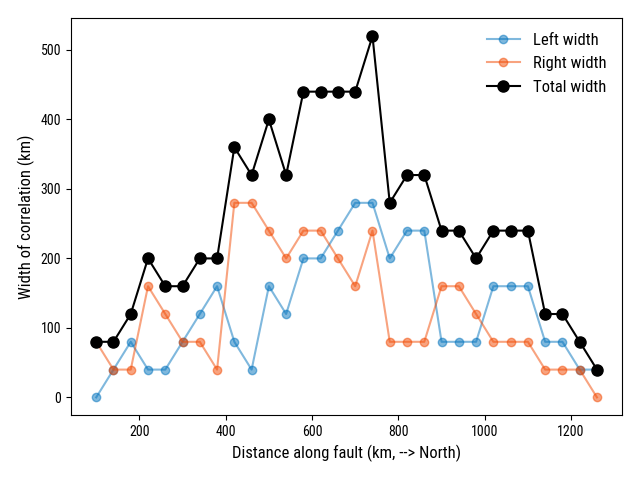

In [ ]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, 'o-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, 'o-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], (np.array(left_width) + np.array(right_width)), 'ko-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

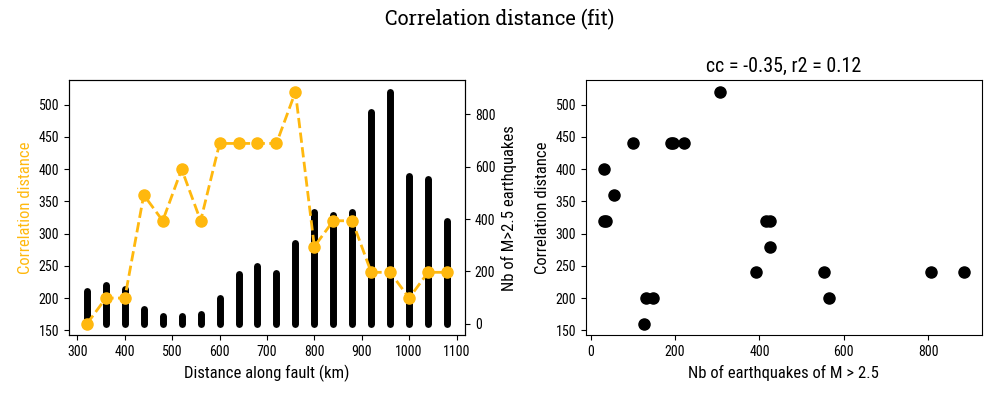

In [ ]:
# So... do they correlate?
corr_dist = np.array(left_width) + np.array(right_width)
n_eq_bin = np.zeros_like(x_bin_edges[:-1])  
dx_eq = 20
for ii in range(len(x_bin_edges)-1):
    n_eq_bin[ii] = len(eq_near[(eq_near.xf >= x_bin_edges[ii]-dx_eq) & (eq_near.xf <= x_bin_edges[ii+1]+dx_eq)])

x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:]) / 2
corr_dist = corr_dist[(x_bin_centers >= xmin_bin + dx_bin*min_fit_points) & (x_bin_centers <= xmax_bin -   dx_bin*min_fit_points)]
n_eq_bin = n_eq_bin[(x_bin_centers >= xmin_bin + dx_bin*min_fit_points) & (x_bin_centers <= xmax_bin - dx_bin*min_fit_points)]
x_bin_centers = x_bin_centers[(x_bin_centers >= xmin_bin + dx_bin*min_fit_points) & (x_bin_centers <= xmax_bin -   dx_bin*min_fit_points)]

# Plot
mag_min = 2.5
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Correlation distance (fit)', fontname='Roboto Slab')

ax = axes[0]
ax.plot(x_bin_centers, corr_dist, 'o--', c='C2', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='C2')
ax.set_xlabel('Distance along fault (km)')

ax_eq = ax.twinx()
X, Y = [], []
for x,y in zip(x_bin_centers, n_eq_bin):
    X.extend([x, x, None]), Y.extend([0, y, None])
ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

ax.set_zorder(ax_eq.get_zorder()+1)
ax.patch.set_visible(False)

ax = axes[1]
ax.plot(n_eq_bin, corr_dist, 'o', c='k', ms=8, lw=2)
ax.set_ylabel('Correlation distance', c='k')
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
cc = np.corrcoef(n_eq_bin, corr_dist)[0, 1]
r2 = 1 - np.sum((corr_dist - np.polyval(np.polyfit(n_eq_bin, corr_dist, 1), n_eq_bin))**2) / np.sum((corr_dist - np.mean(corr_dist))**2)
ax.set_title('cc = {:.2f}, r2 = {:.2f}'.format(cc, r2))

plt.tight_layout()
plt.show()

# 4. <a id='toc4_'></a>Intensity of triggering in the tremor region   [&#128285;](#toc0_)


In [ ]:
# Select earthquakes and tremor to use for this analysis
date_range = [np.datetime64('2009-08-01'), np.datetime64('2024-01-01')]

eq_in_range = eq.copy()
eq_in_range = eq_in_range[(eq_in_range.date >= date_range[0]) & (eq_in_range.date <= date_range[1])]

tremor_in_range = tremor.copy()
tremor_in_range = tremor_in_range[(tremor_in_range.date >= date_range[0]) & (tremor_in_range.date <= date_range[1])]
set_depth = 35.  # in km, because locations are bad

In [ ]:
# Spatially binned baseline rate of tremor that constitutes our background, to check variations against
dx = 2  # spatial spacing of the grid in km
dy = 2  # spatial spacing of the grid in km

x_bins = np.arange(tremor_in_range.xf.min()-dx/2, tremor_in_range.xf.max()+ 3*dx/2, dx)
y_bins = np.arange(tremor_in_range.yf.min()-dx/2, tremor_in_range.yf.max()+3*dy/2, dy)

# Compute the 2D histogram of tremor occurence
H, xedges, yedges = np.histogram2d(tremor_in_range.xf, tremor_in_range.yf, bins=(x_bins, y_bins))

# Make a dataframe cataloguing number of events, x,y center of the cell for all grid cells with tremor in them
x, y = np.meshgrid((xedges[1:] + xedges[:-1])/2, (yedges[1:] + yedges[:-1])/2)
x = x.T.flatten()
y = y.T.flatten()
z = np.ones_like(x) * set_depth
n_ev = H.flatten()
trm_grid = pd.DataFrame({'n_ev': n_ev, 'x': x, 'y': y, 'z': z})

# Remove grid cells with no earthquakes
trm_grid = trm_grid[trm_grid.n_ev > 0]
print('Number of grid cells with tremor: {:d}'.format(len(trm_grid)))

# # Plot
# fig, ax = plt.subplots(1, 1, figsize=(6, 2))

# # Plot the earthquakes
# ax.scatter(tremor_in_range.xf, -tremor_in_range.yf, s=5, c='C1', alpha=0.1)
# ax.scatter(trm_grid.x, -trm_grid.y, s=trm_grid.n_ev/2, c='C0', alpha=0.5)

# plt.tight_layout()
# plt.show()


Number of grid cells with tremor: 33106


## 4.1. <a id='toc4_1_'></a>In time  [&#128285;](#toc0_)

In [40]:
# Parameters
time_bins = np.array([-96, -48, -24, -12, -6, -3, -1, 0, 1, 3, 6, 12, 24, 48, 96]) # in hours
# time_bins = np.arange(-100, 110, 10)  # in hours

dmin = 0
dmax = 20
epicentral = True

# Select which earthquakes to use for triggering analysis
mag_min = 2.
mag_max = 6.
eq_sample = eq_in_range[(eq_in_range.mag >= mag_min) & (eq_in_range.mag <= mag_max)]

print('Number of earthquakes in the sample: {:d}'.format(len(eq_sample)))

Number of earthquakes in the sample: 10076


In [41]:
# Compute the baseline rate of tremor around the selected earthquakes
n_trm_base_count = np.zeros(len(eq_sample))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the cluster location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]
    
    # Compute the distance between the cluster and all grid cells with earthquakes in them
    distances_trm = np.sqrt((trm_grid.x - eq_x)**2 + (trm_grid.y - eq_y)**2 + (trm_grid.z - eq_z)**2)
    
    # Select grid cells that are within the distance range
    eq_grid_sample = trm_grid[(distances_trm >= dmin) & (distances_trm <= dmax)]
    
    # Count the number of earthquakes in each time bin
    n_trm_base_count[ii] = np.sum(eq_grid_sample.n_ev)

# Compute count for each cluster and time bin
n_trm_base = np.zeros((len(time_bins)-1, len(eq_sample)))

for it in range(len(time_bins)-1):
    n_trm_base[it, :] = n_trm_base_count / ((date_range[1] - date_range[0])/np.timedelta64(1, 'h')) * (time_bins[it+1] - time_bins[it])

# Remove the earthquakes that have no tremor around them
eq_sample = eq_sample[n_trm_base_count != 0]
n_trm_base = n_trm_base[:, n_trm_base_count != 0]
print('\nNumber of earthquakes in the sample with tremor around them: {:d}'.format(len(eq_sample)))

Processing earthquake 10076/10076...
Number of earthquakes in the sample with tremor around them: 2973


In [46]:
# Count the number of tremor detections around trigger earthquakes
n_trm = np.zeros((len(time_bins)-1, len(eq_sample)))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the cluster location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]

    # Only consider EQs close to the cluster in time
    trm_sample = tremor_in_range[(tremor_in_range.date >= eq_sample.date[eq_id] - np.timedelta64(time_bins[-1], 'h')) & (tremor_in_range.date <= eq_sample.date[eq_id] + np.timedelta64(time_bins[-1], 'h'))]
    
    # Compute the distance between the cluster and all earthquakes close in time
    distances_trm = np.sqrt((trm_sample.xf - eq_x)**2 + (trm_sample.yf - eq_y)**2 + (set_depth - eq_z)**2)
    
    # Select LFEs that are within the distance range
    trm_sample = trm_sample[(distances_trm >= dmin) & (distances_trm <= dmax)]
    
    # Compute the time difference between the cluster and the earthquakes
    time_diff_trm = (trm_sample.date - eq_sample.date[eq_id]).dt.total_seconds() / 3600  # in hours
    
    # Count the number of earthquakes in each time bin
    n_trm[:, ii], _ = np.histogram(time_diff_trm, bins=time_bins)

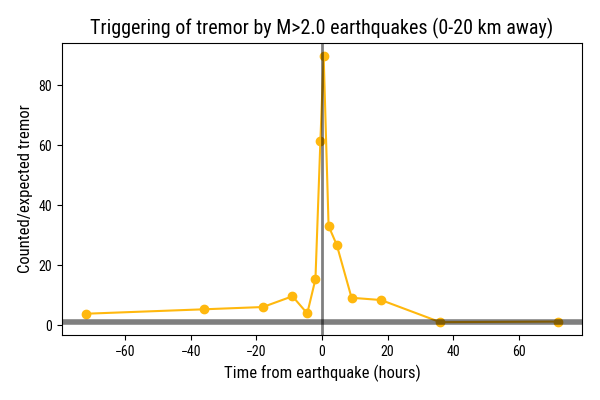

In [47]:
# Results

trm_ratio = n_trm / n_trm_base
# # remove the eq samples responsible for max values for each time bin
# for it in range(len(time_bins)-1):
#     max_idx = np.argsort(trm_ratio[it, :])[::-1][:0]
#     trm_ratio[it, max_idx] = 1
#     print(eq_sample.iloc[max_idx].mag)

trm_mean_ratio = np.mean(trm_ratio, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Time from earthquake (hours)')
ax.set_ylabel('Counted/expected tremor')
ax.set_title('Triggering of tremor by M>{:.1f} earthquakes ({:.0f}-{:.0f} km away)'.format(mag_min, dmin, dmax))

ax.plot((time_bins[1:] + time_bins[:-1]) / 2, trm_mean_ratio, 'o-', c='C2')
ax.axhline(1, c=to_rgba('k', .5), lw=4)
ax.axvline(0, lw=2, c=to_rgba('k', .5))

plt.tight_layout()
plt.show()

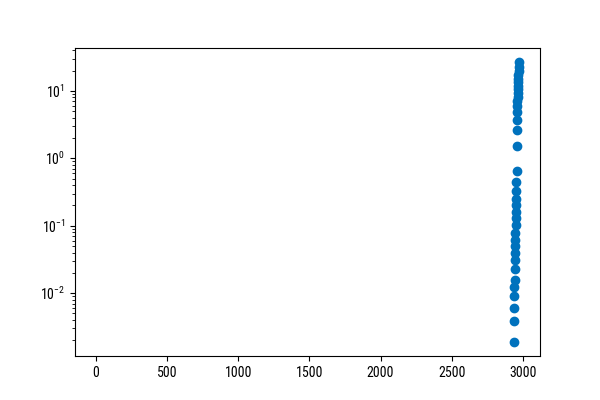

In [58]:
ii = np.where(time_bins[:-1] == 0)
fig, ax = plt.subplots(figsize=(6, 4))
ax.semilogy(np.cumsum(np.sort(trm_ratio[ii[0]+2, :])) / len(eq_sample), 'o')
plt.show()

## 4.2. <a id='toc4_2_'></a>In space [&#128285;](#toc0_)

In [34]:
# Parameters
dist_bins = np.arange(0, 200, 10) # in km
# time_bins = np.arange(-100, 110, 10)  # in hours

tmin = 0
tmax = 20

# Select which earthquakes to use for triggering analysis
mag_min = 2.
eq_sample = eq_in_range[eq_in_range.mag >= mag_min]

print('Number of earthquakes in the sample: {:d}'.format(len(eq_sample)))

Number of earthquakes in the sample: 10085


In [35]:
# # Distance of this earthquake to all lfes and all earthquakes
# def compute_distance(x1, y1, z1, x2, y2, z2, epicentral=True):
#     if epicentral:
#         return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
#     else:
#         return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
                       
# all_trm_eq_dist = compute_distance(eq_sample.xf.values[np.newaxis, :],
#                                    eq_sample.yf.values[np.newaxis, :],
#                                    eq_sample.depth.values[np.newaxis, :],
#                                    trm_grid.x.values[:, np.newaxis],
#                                    trm_grid.y.values[:, np.newaxis],
#                                    trm_grid.z.values[:, np.newaxis])

# weights_trm = np.repeat(trm_grid.n_ev.values, len(eq_sample))

# fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_title('Distances of the sample earthquakes to all tremor locations')
# ax.set_xlabel('Distance from sample earthquake')
# ax.set_ylabel('Number of tremor detections')
# ax.hist(all_trm_eq_dist.flatten(), bins=dist_bins, weights=weights_trm, fc='C2')

# plt.tight_layout()
# plt.show()

In [36]:
# Count the EXPECTED number of tremor detections around trigger earthquakes
epicentral = True

n_trm_base_count = np.zeros((len(dist_bins)-1, len(eq_sample)))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the earthquake location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]

    # Compute the distance between the earthquake and all tremor close in time
    if epicentral:
        distances_trm_grid = np.sqrt((trm_grid.x - eq_x)**2 + (trm_grid.y - eq_y)**2)
    else:
        distances_trm_grid = np.sqrt((trm_grid.x - eq_x)**2 + (trm_grid.y - eq_y)**2 + (trm_grid.z - eq_z)**2)
    
    # Count the number of tremor in each time bin
    n_trm_base_count[:, ii] = np.histogram(distances_trm_grid, bins=dist_bins, weights=trm_grid.n_ev)[0] / ((date_range[1] - date_range[0])/np.timedelta64(1, 'h')) * (tmax - tmin)

# Remove events that are too far from tremor (outside of distance range)
eq_sample = eq_sample[np.sum(n_trm_base_count, axis=0) != 0]
n_trm_base_count = n_trm_base_count[:, np.sum(n_trm_base_count, axis=0) != 0]
print('\nNumber of earthquakes in the sample with tremor around them: {:d}'.format(len(eq_sample)))

Processing earthquake 10085/10085...
Number of earthquakes in the sample with tremor around them: 9774


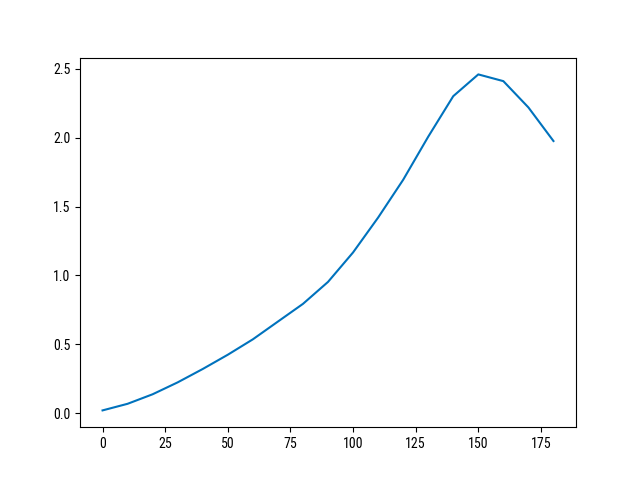

In [37]:
plt.figure()
plt.plot(dist_bins[:-1], np.mean(n_trm_base_count, axis=1))
plt.show()

In [38]:
# Count the number of tremor detections around trigger earthquakes
n_trm = np.zeros((len(dist_bins)-1, len(eq_sample)))

for ii, eq_id in enumerate(eq_sample.index):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Get the earthquake location
    eq_x = eq_sample.xf[eq_id]
    eq_y = eq_sample.yf[eq_id]
    eq_z = eq_sample.depth[eq_id]

    # Only consider tremor close to the eurthqake in time
    trm_sample = tremor_in_range[(tremor_in_range.date >= eq_sample.date[eq_id] - np.timedelta64(tmin, 'h')) & (tremor_in_range.date <= eq_sample.date[eq_id] + np.timedelta64(tmax, 'h'))]
    
    # Compute the distance between the earthquake and all tremor close in time
    if epicentral:
        distances_trm = np.sqrt((trm_sample.xf - eq_x)**2 + (trm_sample.yf - eq_y)**2)
    else:
        distances_trm = np.sqrt((trm_sample.xf - eq_x)**2 + (trm_sample.yf - eq_y)**2 + (set_depth - eq_z)**2)
    
    # Count the number of tremor in each time bin
    n_trm[:, ii], _ = np.histogram(distances_trm, bins=dist_bins)


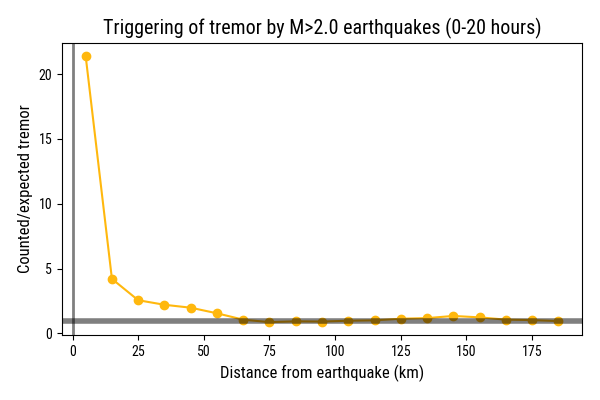

In [39]:
# Results
trm_mean_ratio = np.mean(n_trm, axis=1) / np.mean(n_trm_base_count, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Distance from earthquake (km)')
ax.set_ylabel('Counted/expected tremor')
ax.set_title('Triggering of tremor by M>{:.1f} earthquakes ({:.0f}-{:.0f} hours)'.format(mag_min, tmin, tmax))

ax.plot((dist_bins[1:] + dist_bins[:-1]) / 2, trm_mean_ratio, 'o-', c='C2')
ax.axhline(1, c=to_rgba('k', .5), lw=4)
ax.axvline(0, lw=2, c=to_rgba('k', .5))

plt.tight_layout()
plt.show()
